!python --version

In [2]:
!python -m pip install --upgrade pip

!pip install supervision==0.3.0

!pip install transformers

!pip install pytorch-lightning

!pip install timm

!pip install cython

!pip install pycocotools

!pip install scipy

!pip install roboflow

In [3]:
!pip --version

pip 25.0.1 from C:\Users\hp\AppData\Local\Programs\Python\Python311\Lib\site-packages\pip (python 3.11)



In [4]:
import torch #for deep learning and tensor computations.
torch.__version__

'2.6.0+cpu'

In [5]:
import supervision as sv #helps with computer vision tasks like object detection
import transformers #Provides pre-trained models

sv.__version__ , transformers.__version__

('0.3.0', '4.48.3')

In [6]:
import pytorch_lightning #manage training loops
print(pytorch_lightning.__version__)

2.5.0.post0


In [7]:
import os
import torchvision#Provides pre-trained models
from transformers import DetrImageProcessor
image_processor = DetrImageProcessor.from_pretrained("facebook/detr-resnet-50")

dataset = './bone fracture.v2-release.coco/'

ANNOTATION_FILE_NAME = "_annotations.coco.json"
TRAIN_DIRECTORY = os.path.join(dataset, "train")
VAL_DIRECTORY = os.path.join(dataset, "valid")
TEST_DIRECTORY = os.path.join(dataset, "test")


class CocoDetection(torchvision.datasets.CocoDetection): #Inherits from torchvision.datasets.CocoDetection, which automatically loads COCO-formatted data
    def __init__(
        self, 
        image_directory_path: str, 
        image_processor, 
        train: bool = True
    ):
        annotation_file_path = os.path.join(image_directory_path, ANNOTATION_FILE_NAME) #Finds the annotation file (_annotations.coco.json) inside the dataset directory
        super(CocoDetection, self).__init__(image_directory_path, annotation_file_path)
        self.image_processor = image_processor

    def __getitem__(self, idx):
        images, annotations = super(CocoDetection, self).__getitem__(idx)   #to load an image and its annotations     
        image_id = self.ids[idx]
        annotations = {'image_id': image_id, 'annotations': annotations}
        encoding = self.image_processor(images=images, annotations=annotations, return_tensors="pt")
        pixel_values = encoding["pixel_values"].squeeze()
        target = encoding["labels"][0]

        return pixel_values, target


TRAIN_DATASET = CocoDetection(image_directory_path=TRAIN_DIRECTORY, image_processor=image_processor, train=True)
VAL_DATASET = CocoDetection(image_directory_path=VAL_DIRECTORY, image_processor=image_processor, train=False)
TEST_DATASET = CocoDetection(image_directory_path=TEST_DIRECTORY, image_processor=image_processor, train=False)

print("Number of training examples:", len(TRAIN_DATASET))
print("Number of validation examples:", len(VAL_DATASET))
print("Number of test examples:", len(TEST_DATASET))

loading annotations into memory...
Done (t=0.01s)
creating index...
index created!
loading annotations into memory...
Done (t=0.01s)
creating index...
index created!
loading annotations into memory...
Done (t=0.01s)
creating index...
index created!
Number of training examples: 326
Number of validation examples: 88
Number of test examples: 44


Image #139


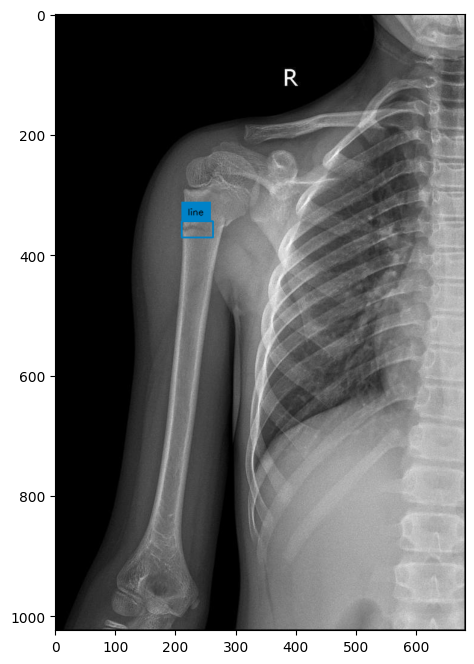

In [8]:
# Visualize if dataset is loaded properly

import random
import cv2
import numpy as np


# select random image
image_ids = TRAIN_DATASET.coco.getImgIds()
image_id = random.choice(image_ids)
print('Image #{}'.format(image_id))

# load image and annotatons 
image = TRAIN_DATASET.coco.loadImgs(image_id)[0]
annotations = TRAIN_DATASET.coco.imgToAnns[image_id]
image_path = os.path.join(TRAIN_DATASET.root, image['file_name'])
image = cv2.imread(image_path)

# annotate
detections = sv.Detections.from_coco_annotations(coco_annotation=annotations)

# we will use id2label function for training
categories = TRAIN_DATASET.coco.cats
id2label = {k: v['name'] for k,v in categories.items()}

labels = [
    f"{id2label[class_id]}" 
    for _, _, class_id, _ 
    in detections
]

box_annotator = sv.BoxAnnotator()
frame = box_annotator.annotate(scene=image, detections=detections, labels=labels)

%matplotlib inline  
sv.show_frame_in_notebook(image, (8, 8))

In [9]:
from torch.utils.data import DataLoader

def collate_fn(batch):
    pixel_values = [item[0] for item in batch]
    encoding = image_processor.pad(pixel_values, return_tensors="pt")
    labels = [item[1] for item in batch]
    return {
        'pixel_values': encoding['pixel_values'],
        'pixel_mask': encoding['pixel_mask'],
        'labels': labels
    }

TRAIN_DATALOADER = DataLoader(dataset=TRAIN_DATASET, collate_fn=collate_fn, batch_size=4, shuffle=True)
VAL_DATALOADER = DataLoader(dataset=VAL_DATASET, collate_fn=collate_fn, batch_size=4)
TEST_DATALOADER = DataLoader(dataset=TEST_DATASET, collate_fn=collate_fn, batch_size=4)

# Train model with PyTorch Lightning

The DETR model is loaded using the Hugging Face Transformers library

In [10]:
import pytorch_lightning as pl
from transformers import DetrForObjectDetection
import torch


class Detr(pl.LightningModule):

    def __init__(self, lr, lr_backbone, weight_decay):
        super().__init__()# Calls the base class 
        self.model = DetrForObjectDetection.from_pretrained(
            pretrained_model_name_or_path="facebook/detr-resnet-50", 
            num_labels=len(id2label),# Number of object categories
            ignore_mismatched_sizes=True# Allows fine-tuning with different label sizes
        )
        # Hyperparameters for training
        self.lr = lr# Learning rate for the model
        self.lr_backbone = lr_backbone# Separate learning rate for the backbone
        self.weight_decay = weight_decay # Regularization to prevent overfitting
        
# Forward pass: takes input image tensors and returns model predictions
    def forward(self, pixel_values, pixel_mask): 
        return self.model(pixel_values=pixel_values, pixel_mask=pixel_mask)
 
    # Common function for training and validation steps
    def common_step(self, batch, batch_idx):
        pixel_values = batch["pixel_values"] # Input images
        pixel_mask = batch["pixel_mask"] # Mask for padding in input images
        labels = [{k: v.to(self.device) for k, v in t.items()} for t in batch["labels"]]

        outputs = self.model(pixel_values=pixel_values, pixel_mask=pixel_mask, labels=labels)

        loss = outputs.loss  # Total loss
        loss_dict = outputs.loss_dict

        return loss, loss_dict

    def training_step(self, batch, batch_idx):
        loss, loss_dict = self.common_step(batch, batch_idx)     
        # logs metrics for each training_step, and the average across the epoch
        self.log("training_loss", loss)
        for k,v in loss_dict.items():
            self.log("train_" + k, v.item())

        return loss

    def validation_step(self, batch, batch_idx):
        loss, loss_dict = self.common_step(batch, batch_idx)     
        self.log("validation/loss", loss)
        for k, v in loss_dict.items():
            self.log("validation_" + k, v.item())
            
        return loss

    def configure_optimizers(self):
         # DETR authors use different learning rates for backbone and other layers
        param_dicts = [
            {
                "params": [p for n, p in self.named_parameters() if "backbone" not in n and p.requires_grad]},
            {
                "params": [p for n, p in self.named_parameters() if "backbone" in n and p.requires_grad],
                "lr": self.lr_backbone,
            },
        ]
        return torch.optim.AdamW(param_dicts, lr=self.lr, weight_decay=self.weight_decay)
        
 # Define training dataloader (assumes TRAIN_DATALOADER is defined elsewhere)
    def train_dataloader(self):
        return TRAIN_DATALOADER
    # Define validation dataloader (assumes VAL_DATALOADER is defined elsewhere)

    def val_dataloader(self):
        return VAL_DATALOADER

In [11]:
model = Detr(lr=1e-4, lr_backbone=1e-5, weight_decay=1e-4)# Instantiate the model 

batch = next(iter(TRAIN_DATALOADER))# Fetch the next batch from the training dataloader
outputs = model(pixel_values=batch['pixel_values'], pixel_mask=batch['pixel_mask'])# Run the batch through the model to get predictions

Some weights of the model checkpoint at facebook/detr-resnet-50 were not used when initializing DetrForObjectDetection: ['model.backbone.conv_encoder.model.layer1.0.downsample.1.num_batches_tracked', 'model.backbone.conv_encoder.model.layer2.0.downsample.1.num_batches_tracked', 'model.backbone.conv_encoder.model.layer3.0.downsample.1.num_batches_tracked', 'model.backbone.conv_encoder.model.layer4.0.downsample.1.num_batches_tracked']
- This IS expected if you are initializing DetrForObjectDetection from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DetrForObjectDetection from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of DetrForObjectDetection were not initialized from the model checkpoin

In [ ]:
# import torch
# from pytorch_lightning import Trainer

# # Optimize CPU threading
# torch.set_num_threads(8)  # Adjust based on available cores

# trainer = Trainer(
#     max_epochs=50,  # Reduce if needed
#     accelerator="cpu",  
#     log_every_n_steps=100,  # Reduce logging frequency
#     accumulate_grad_batches=2  # Reduce accumulation if possible
# )
# trainer.fit(model)

In [14]:
from pytorch_lightning import Trainer

# Optimize CPU threading
torch.set_num_threads(8)  # Adjust based on available cores

# settings
MAX_EPOCHS = 10

trainer = Trainer( max_epochs=MAX_EPOCHS, accelerator="cpu",gradient_clip_val=0.1, accumulate_grad_batches=2, log_every_n_steps=100)

trainer.fit(model)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name  | Type                   | Params | Mode
--------------------------------------------------------
0 | model | DetrForObjectDetection | 41.5 M | eval
--------------------------------------------------------
41.3 M    Trainable params
222 K     Non-trainable params
41.5 M    Total params
166.011   Total estimated model params size (MB)
0         Modules in train mode
399       Modules in eval mode


Sanity Checking: |                                                                               | 0/? [00:00<…

Training: |                                                                                      | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

`Trainer.fit` stopped: `max_epochs=10` reached.


# Save and load model

In [17]:
import torch

# Define device
DEVICE = torch.device("cpu")

MODEL_PATH = "custom-model-new"
model.model.save_pretrained(MODEL_PATH)

# Load model
model = DetrForObjectDetection.from_pretrained(MODEL_PATH)
model.to(DEVICE)  # Move model to CPU


Some weights of DetrForObjectDetection were not initialized from the model checkpoint at custom-model-new and are newly initialized: ['bbox_predictor.layers.0.bias', 'bbox_predictor.layers.0.weight', 'bbox_predictor.layers.1.bias', 'bbox_predictor.layers.1.weight', 'bbox_predictor.layers.2.bias', 'bbox_predictor.layers.2.weight', 'class_labels_classifier.bias', 'class_labels_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


DetrForObjectDetection(
  (model): DetrModel(
    (backbone): DetrConvModel(
      (conv_encoder): DetrConvEncoder(
        (model): FeatureListNet(
          (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
          (bn1): DetrFrozenBatchNorm2d()
          (act1): ReLU(inplace=True)
          (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
          (layer1): Sequential(
            (0): Bottleneck(
              (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
              (bn1): DetrFrozenBatchNorm2d()
              (act1): ReLU(inplace=True)
              (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
              (bn2): DetrFrozenBatchNorm2d()
              (drop_block): Identity()
              (act2): ReLU(inplace=True)
              (aa): Identity()
              (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      

In [15]:

# MODEL_PATH = 'custom-model'
# model.model.save_pretrained(MODEL_PATH)

# # loading model
# model = DetrForObjectDetection.from_pretrained(MODEL_PATH)
# model.to(DEVICE)

NameError: name 'DEVICE' is not defined

# Inference on test dataset

Let's visualize the predictions of DETR on the first image of the validation set.

Image #36


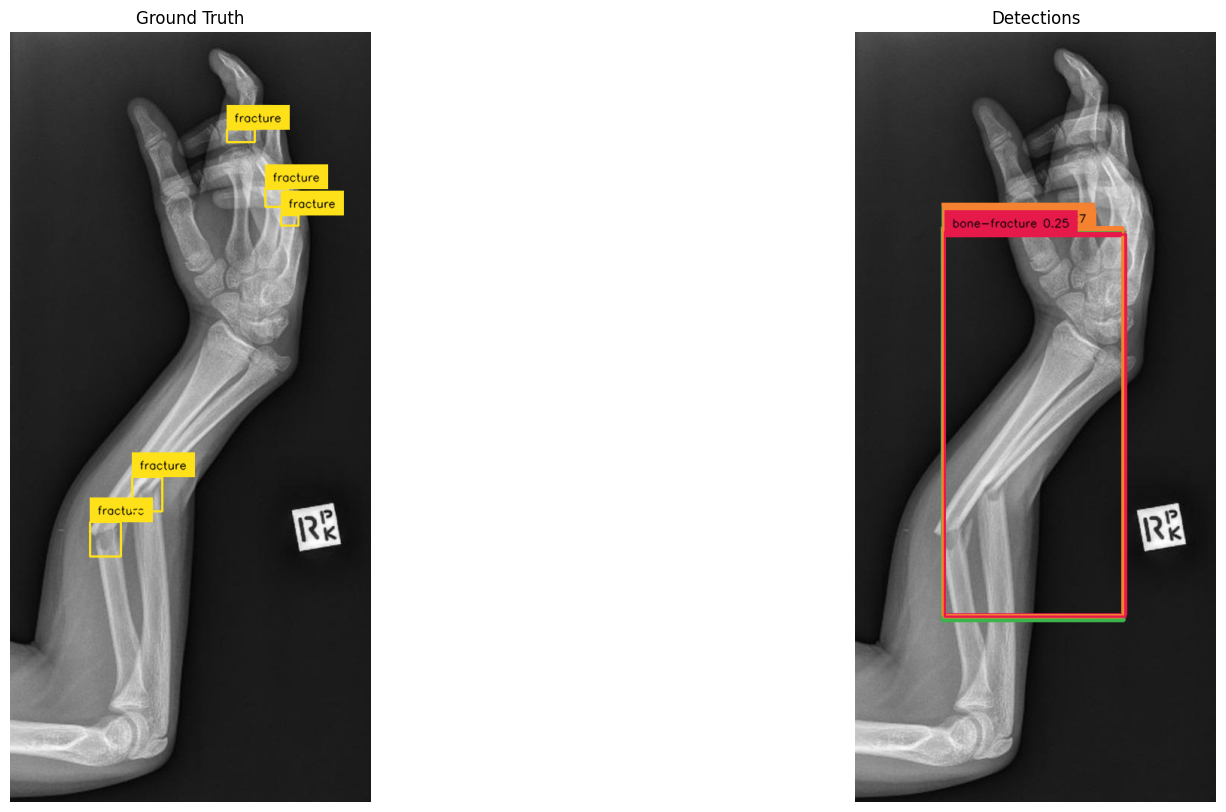

In [21]:
import random
import cv2
import numpy as np
import matplotlib.pyplot as plt


# utils
categories = TEST_DATASET.coco.cats
id2label = {k: v['name'] for k,v in categories.items()} # Convert category ID to label name
box_annotator = sv.BoxAnnotator() # Utility for annotating bounding boxes

# select random image
image_ids = TEST_DATASET.coco.getImgIds()# Get all image IDs
image_id = random.choice(image_ids)# Select a random image
print('Image #{}'.format(image_id))

# load image and annotatons 
image = TEST_DATASET.coco.loadImgs(image_id)[0]  # Get image metadata
annotations = TEST_DATASET.coco.imgToAnns[image_id] # Get annotations for the image
image_path = os.path.join(TEST_DATASET.root, image['file_name']) # Get the image file path
image = cv2.imread(image_path)  # Load the image using OpenCV


# Annotate detections
with torch.no_grad():  #Disables gradient calculations to save memory & improve speed

    # load image and predict
    inputs = image_processor(images=image, return_tensors='pt').to(DEVICE) # Convert image to tensor
    outputs = model(**inputs) #Passes the image through the DETR model

    # post-process
    target_sizes = torch.tensor([image.shape[:2]]).to(DEVICE)
    results = image_processor.post_process_object_detection(
        outputs=outputs, 
        threshold=CONFIDENCE_TRESHOLD, # Confidence threshold for detection
        target_sizes=target_sizes
    )[0]


    detections = sv.Detections.from_transformers(transformers_results=results) # Convert to Supervision format
    labels = [f"{id2label[class_id]} {confidence:.2f}" for _, confidence, class_id, _ in detections]# Format labels
    frame_detections = box_annotator.annotate(scene=image.copy(), detections=detections, labels=labels) # Draw boxes

fig, axs = plt.subplots(1, 2, figsize=(20, 10))# Create 1 row, 2 column subplot
axs[0].imshow(cv2.cvtColor(frame_ground_truth, cv2.COLOR_BGR2RGB))
axs[0].axis('off')
axs[0].set_title('Ground Truth')

axs[1].imshow(cv2.cvtColor(frame_detections, cv2.COLOR_BGR2RGB))
axs[1].axis('off')
axs[1].set_title('Detections')

plt.show()